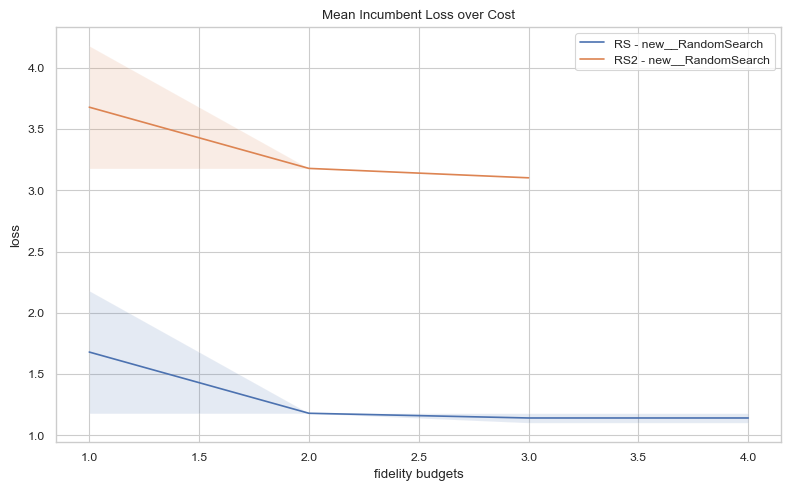

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from pathlib import Path
from collections import defaultdict



def extract_all_results(results_root, loss_key="objective_to_minimize", cost_key="cost"):
    results_root = Path(results_root)
    if not results_root.is_dir():
        raise ValueError(f"Provided path {results_root} is not a directory.")

    results = {}
    results["seeds"] = []

    for subdir in results_root.iterdir():
        seed = subdir.name
        # Load the optimizer name from the optimizer_info.yaml file
        optimizer_info_path = subdir / "optimizer_info.yaml"
        with open(optimizer_info_path, 'r') as f:
            optimizer_info = yaml.safe_load(f)
        optimizer_name = optimizer_info.get("name")
        results[seed] = {}
        results["seeds"].append(seed)

        is_multi_fidelity = len(next(subdir.glob("configs/config_*")).name.split("/")[-1].split("_"))>2
        

        for config_dir in subdir.glob("configs/config_*"):
            config_id = int(config_dir.name.split("/")[-1].split("_")[1])
            # Load the report.yaml file
            results_file = config_dir / "report.yaml"
            with open(results_file, 'r') as f:
                results_data = yaml.safe_load(f)
            # Extract the loss value
            if is_multi_fidelity:
                if config_id not in results[seed]:
                    results[seed][config_id] = {}
                fidelity = results_data[cost_key]
                loss_value = results_data[loss_key]
                results[seed][config_id][fidelity] = loss_value
            else:
                loss_value = results_data[loss_key]
                results[seed][config_id] = loss_value
        results["optimizer_name"] = optimizer_name
        results["multi_fidelity"] = is_multi_fidelity
    return results


def plot_incumbent_loss_curves(
    results_root,
    experiments:list[str],
    ylabel="Loss", 
    xlabel="Cost",
    title="Mean Incumbent Loss", 
    fidelity_multiples=False,
):
    """
    Plot mean incumbent loss over iterations or cost for multiple optimizers.
    """
    sns.set_theme(style="whitegrid")
    sns.set_context("paper")
    plt.figure(figsize=(8, 5))
    results = {}

    for subdir in Path(results_root).iterdir():
        if str(subdir).split("\\")[-1] in experiments:
            subdir_results = extract_all_results(subdir)
            results[subdir.name] = subdir_results

    # import pprint
    # pprint.pprint(results)

    for experiment_name, seeds_dicts in results.items():
        all_curves = []
        all_xs = []
        exp_scores = {}
        optimizer_name = seeds_dicts.get("optimizer_name", "Unknown")
        seeds = seeds_dicts.get("seeds", [])
        is_multi_fidelity = seeds_dicts["multi_fidelity"]

        if not is_multi_fidelity:

            for seed in seeds:
                iteration_loss_dict = seeds_dicts[seed]
                # If experiment is not multi-fidelity, we can directly use the loss values            
                    # Prepare the cost-loss pairs
                cost_loss_list = []
                for cost, loss in iteration_loss_dict.items():
                    cost_loss_list.append((cost, loss))
                exp_scores[seed] = cost_loss_list
            
                xs = [float(c) for c, _ in cost_loss_list]
                losses = [l for _, l in cost_loss_list]
                incumbents = np.minimum.accumulate(losses)
                xs = xs[:len(incumbents)]
                all_curves.append(pd.Series(incumbents, index=xs))
                all_xs.append(xs)

            max_len = int(max(len(x) for x in all_xs))
            df = pd.DataFrame([curve.reindex(range(1, max_len + 1), method="ffill") for curve in all_curves])
            means = df.mean(axis=0)
            sem = df.sem(axis=0)
            plt.plot(range(1, max_len + 1), means, label=experiment_name + " - " + optimizer_name)
            plt.fill_between(range(1, max_len + 1), means - sem, means + sem, alpha=0.15)
            
        else:
            max_fidelity_seed = 0
            for seed in seeds:
                iteration_loss_dict = seeds_dicts[seed]
                # Prepare the cost-loss pairs for multi-fidelity
                cost_loss_list = []
                for config_id, fidelity_loss_dict in iteration_loss_dict.items():
                    max_fidelity_config = max(fidelity_loss_dict.keys(), key=float)
                    cost_loss_list.append((max_fidelity_config, fidelity_loss_dict[max_fidelity_config]))
                    max_fidelity_seed = max(max_fidelity_seed, max_fidelity_config)
                exp_scores[seed] = cost_loss_list
                xs = [float(f) for f, _ in cost_loss_list]
                losses = [l for _, l in cost_loss_list]
                incumbents = np.minimum.accumulate(losses)
                xs = xs[:len(incumbents)]
                xs = [sum(xs[:i+1]) for i in range(len(xs))]  # Cumulative cost
                all_curves.append(pd.Series(incumbents, index=xs))
                all_xs.append(xs)

            df = pd.DataFrame(all_curves).transpose().sort_index().ffill(limit_area='inside').cummin()
            means = df.mean(axis=1, skipna=True)
            sem = df.sem(axis=1,skipna=True).replace(np.nan, 0.0)
                
            
            if fidelity_multiples:
                df.index = [float(x)/max_fidelity_seed for x in df.index]
                x_ticks = np.concatenate([np.array([0.5,1,1.5,2,5])* 10**i for i in range(0,int(np.ceil(max(df.index))))])
                x_filtered = x_ticks[x_ticks <= max(df.index)]
                x_filtered = np.append(x_filtered,x_ticks[len(x_filtered)])
                plt.xlim(min(df.index), max(x_filtered))
                plt.xticks(x_filtered, [str(np.round(tick,2))+"x" for tick in x_filtered])
            plt.plot(df.index, means, label=experiment_name + " - " + optimizer_name)
            plt.fill_between(df.index, means - sem, means + sem, alpha=0.15)

    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == "__main__":
    results_root = r"c:\Users\lenak\OFFLINE_FILES\Anton\Git\neps-lum\results"
    experiments = ["RS2","RS"]
    
    import pprint
    # pprint.pprint(results)
    plot_incumbent_loss_curves(
        results_root,
        experiments=experiments,
        ylabel="loss",
        xlabel="fidelity budgets",
        title="Mean Incumbent Loss over Cost",
        fidelity_multiples=False
    )

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from pathlib import Path
from collections import defaultdict



def extract_all_results(results_root, loss_key="objective_to_minimize", cost_key="cost"):
    results_root = Path(results_root)
    if not results_root.is_dir():
        raise ValueError(f"Provided path {results_root} is not a directory.")

    results = {}
    results["seeds"] = []

    for subdir in results_root.iterdir():
        seed = subdir.name
        # Load the optimizer name from the optimizer_info.yaml file
        optimizer_info_path = subdir / "optimizer_info.yaml"
        with open(optimizer_info_path, 'r') as f:
            optimizer_info = yaml.safe_load(f)
        optimizer_name = optimizer_info.get("name")
        results[seed] = {}
        results["seeds"].append(seed)

        is_multi_fidelity = len(next(subdir.glob("configs/config_*")).name.split("/")[-1].split("_"))>2
        

        for config_dir in subdir.glob("configs/config_*"):
            config_id = int(config_dir.name.split("/")[-1].split("_")[1])
            # Load the report.yaml file
            results_file = config_dir / "report.yaml"
            with open(results_file, 'r') as f:
                results_data = yaml.safe_load(f)
            # Extract the loss value
            if is_multi_fidelity:
                if config_id not in results[seed]:
                    results[seed][config_id] = {}
                fidelity = results_data[cost_key]
                loss_value = results_data[loss_key]
                results[seed][config_id][fidelity] = loss_value
            else:
                loss_value = results_data[loss_key]
                results[seed][config_id] = loss_value
        results["optimizer_name"] = optimizer_name
        results["multi_fidelity"] = is_multi_fidelity
    return results


def plot_incumbent_loss_curves(
    results_root,
    experiments:list[str],
    ylabel="Loss", 
    xlabel="Cost",
    title="Mean Incumbent Loss", 
    fidelity_multiples=False,
):
    """
    Plot mean incumbent loss over iterations or cost for multiple optimizers.
    """
    sns.set_theme(style="whitegrid")
    sns.set_context("paper")
    plt.figure(figsize=(8, 5))
    results = {}

    for subdir in Path(results_root).iterdir():
        if str(subdir).split("\\")[-1] in experiments:
            subdir_results = extract_all_results(subdir)
            results[subdir.name] = subdir_results

    # import pprint
    # pprint.pprint(results)

    for experiment_name, seeds_dicts in results.items():
        all_curves = []
        all_xs = []
        exp_scores = {}
        optimizer_name = seeds_dicts.get("optimizer_name", "Unknown")
        seeds = seeds_dicts.get("seeds", [])
        is_multi_fidelity = seeds_dicts["multi_fidelity"]

        if not is_multi_fidelity:

            for seed in seeds:
                iteration_loss_dict = seeds_dicts[seed]
                # If experiment is not multi-fidelity, we can directly use the loss values            
                    # Prepare the cost-loss pairs
                cost_loss_list = []
                for cost, loss in iteration_loss_dict.items():
                    cost_loss_list.append((cost, loss))
                exp_scores[seed] = cost_loss_list
            
                xs = [float(c) for c, _ in cost_loss_list]
                losses = [l for _, l in cost_loss_list]
                incumbents = np.minimum.accumulate(losses)
                xs = xs[:len(incumbents)]
                all_curves.append(pd.Series(incumbents, index=xs))
                all_xs.append(xs)

            max_len = int(max(len(x) for x in all_xs))
            df = pd.DataFrame([curve.reindex(range(1, max_len + 1), method="ffill") for curve in all_curves])
            means = df.mean(axis=0)
            sem = df.sem(axis=0)
            plt.plot(range(1, max_len + 1), means, label=experiment_name + " - " + optimizer_name)
            plt.fill_between(range(1, max_len + 1), means - sem, means + sem, alpha=0.15)
            
        else:
            max_fidelity_seed = 0
            for seed in seeds:
                iteration_loss_dict = seeds_dicts[seed]
                # Prepare the cost-loss pairs for multi-fidelity
                cost_loss_list = []
                for config_id, fidelity_loss_dict in iteration_loss_dict.items():
                    max_fidelity_config = max(fidelity_loss_dict.keys(), key=float)
                    cost_loss_list.append((max_fidelity_config, fidelity_loss_dict[max_fidelity_config]))
                    max_fidelity_seed = max(max_fidelity_seed, max_fidelity_config)
                exp_scores[seed] = cost_loss_list
                xs = [float(f) for f, _ in cost_loss_list]
                losses = [l for _, l in cost_loss_list]
                incumbents = np.minimum.accumulate(losses)
                xs = xs[:len(incumbents)]
                xs = [sum(xs[:i+1]) for i in range(len(xs))]  # Cumulative cost
                all_curves.append(pd.Series(incumbents, index=xs))
                all_xs.append(xs)

            df = pd.DataFrame(all_curves).transpose().sort_index().ffill(limit_area='inside').cummin()
            means = df.mean(axis=1, skipna=True)
            sem = df.sem(axis=1,skipna=True).replace(np.nan, 0.0)
                
            
            if fidelity_multiples:
                df.index = [float(x)/max_fidelity_seed for x in df.index]
                x_ticks = np.concatenate([np.array([0.5,1,1.5,2,5])* 10**i for i in range(0,int(np.ceil(max(df.index))))])
                x_filtered = x_ticks[x_ticks <= max(df.index)]
                x_filtered = np.append(x_filtered,x_ticks[len(x_filtered)])
                plt.xlim(min(df.index), max(x_filtered))
                plt.xticks(x_filtered, [str(np.round(tick,2))+"x" for tick in x_filtered])
            plt.plot(df.index, means, label=experiment_name + " - " + optimizer_name)
            plt.fill_between(df.index, means - sem, means + sem, alpha=0.15)

    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == "__main__":
    results_root = r"c:\Users\lenak\OFFLINE_FILES\Anton\Git\neps-lum\results"
    experiments = ["RS2","RS"]
    
    import pprint
    # pprint.pprint(results)
    plot_incumbent_loss_curves(
        results_root,
        experiments=experiments,
        ylabel="loss",
        xlabel="fidelity budgets",
        title="Mean Incumbent Loss over Cost",
        fidelity_multiples=False
    )

(0.0, 5.0)

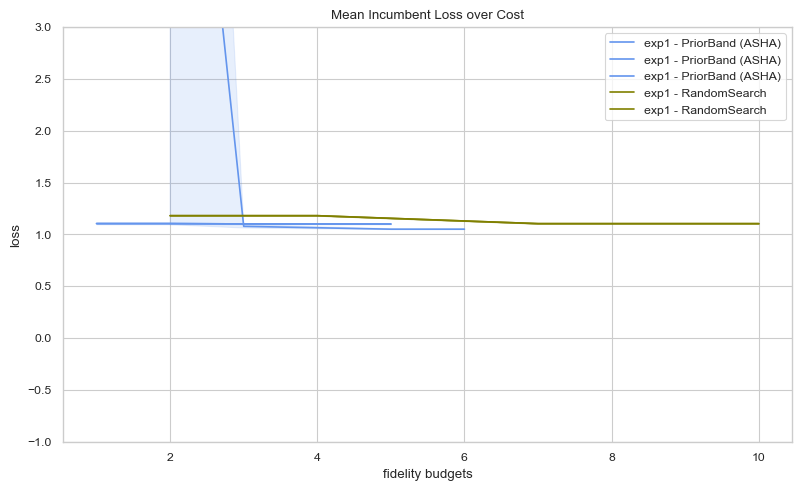

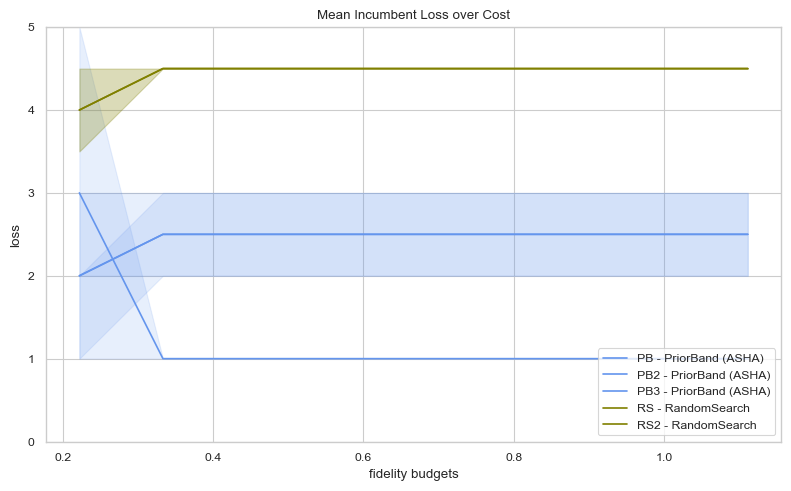

In [12]:
import neps
import pandas as pd
from pathlib import Path
from pathlib import Path
from typing import Literal
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

from neps.space.new_space.plotting import plot_experiment_loss

path = Path(r"c:\Users\lenak\OFFLINE_FILES\Anton\Git\neps-lum\results\exp1")
fig, ax = plt.subplots(figsize=(8, 5))
ax = plot_experiment_loss(path, 
                          ax=ax,
                     ylabel="loss",
                     xlabel="fidelity budgets",
                     title="Mean Incumbent Loss over Cost",
                     y_axis="cost",
                     max_fidelity=2,
                     )
plt.tight_layout()
ax.set_ylim(-1,3)

from neps.space.new_space.plotting import plot_experiments_ranks

path = Path(r"c:\Users\lenak\OFFLINE_FILES\Anton\Git\neps-lum\results\exp1")
fig, ax = plt.subplots(figsize=(8, 5))
ax = plot_experiments_ranks(path, 
                    ax=ax,
                     ylabel="loss",
                     xlabel="fidelity budgets",
                     title="Mean Incumbent Loss over Cost",
                     y_axis="evaluation",
                     max_fidelity=3,
                     )
plt.tight_layout()
ax.set_ylim(top=5)
